# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

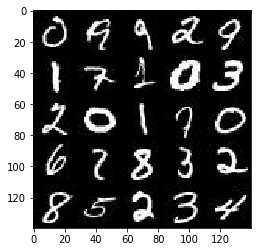

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

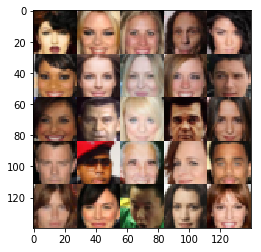

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # zero pad to get 32x32 images
        images = tf.pad(images, [[0, 0], [2, 2], [2, 2], [0, 0]])
        # 32x32x1/3
        
        z1 = tf.layers.conv2d(
            inputs=images,
            filters=64,
            kernel_size=5,
            strides=2,
            padding='same'
        )
        a1 = tf.maximum(alpha*z1, z1)
        # 16x16x64
        
        z2 = tf.layers.conv2d(
            inputs=a1,
            filters=128,
            kernel_size=5,
            strides=2,
            padding='same'
        )
        bn2 = tf.layers.batch_normalization(z2, training=True)
        a2 = tf.maximum(alpha*bn2, bn2)
        # 8x8x128
        
        z3 = tf.layers.conv2d(
            inputs=a2,
            filters=256,
            kernel_size=5,
            strides=2,
            padding='same'
        )
        bn3 = tf.layers.batch_normalization(z3, training=True)
        a3 = tf.maximum(alpha*bn3, bn3)
        # 4x4x256
        
        flat = tf.reshape(a3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [34]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        x = tf.layers.dense(
            inputs=z,
            units=4*4*512
        )
        z1 = tf.reshape(x, (-1, 4, 4, 512))
        bn1 = tf.layers.batch_normalization(z1, training=is_train)
        a1 = tf.maximum(alpha*bn1, bn1)
        # 4x4x512
        
        z2 = tf.layers.conv2d_transpose(
            inputs=a1,
            filters=256,
            kernel_size=5,
            strides=2,
            padding='same'
        )
        bn2 = tf.layers.batch_normalization(z2, training=is_train)
        a2 = tf.maximum(alpha*bn2, bn2)
        # 8x8x256
    
        z3 = tf.layers.conv2d_transpose(
            inputs=a2,
            filters=128,
            kernel_size=5,
            strides=2,
            padding='same'
        )
        bn3 = tf.layers.batch_normalization(z3, training=is_train)
        a3 = tf.maximum(alpha*bn3, bn3)
        # 16x16x128
        
        # output layer (32x32xout_channel_dim):
        logits_uncropped = tf.layers.conv2d_transpose(
            inputs=a3,
            filters=out_channel_dim,
            kernel_size=5,
            strides=2,
            padding='same'
        )
        # 32x32xout_channel_dim
        
        #crop middle 28x28 pixels
        logits = tf.slice(
            logits_uncropped,
            [0, 2, 2, 0],
            [-1, 28, 28, -1]
        )
        # logits: 28x28xout_channel_dim
        
        output = 0.5*tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=0.9*tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})
    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [31]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_width = data_shape[2]
    image_height = data_shape[1]
    image_channels = data_shape[3]
    print(image_height, image_width, image_channels)
    inputs_real, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # sample random noise for z vector:
                batch_z = np.random.uniform(-1, 1,size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={
                    inputs_real: batch_images,
                    inputs_z: batch_z,
                    lr: learning_rate
                })
                _ = sess.run(g_opt, feed_dict={
                    inputs_z: batch_z,
                    inputs_real: batch_images,
                    lr: learning_rate
                })
                if steps % 20 == 0:
                    train_loss_d = sess.run(d_loss, feed_dict={
                        inputs_real: batch_images,
                        inputs_z: batch_z
                    })
                    train_loss_g = sess.run(g_loss, feed_dict={
                        inputs_z: batch_z
                    })
                    
                    print('Epoch {}/{}:\tDLoss: {:.4f}, GLoss: {:.4f}'.format(
                        epoch_i, epoch_count, train_loss_d, train_loss_g
                    ))
                if steps % 100 == 0:
                    image_mode = "RGB" if image_channels == 3 else "L"
                    n_images = 16
                    show_generator_output(sess, n_images, inputs_z, image_channels, image_mode)
                steps += 1
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

28 28 1
Epoch 0/2:	DLoss: 3.8381, GLoss: 0.0397
Image mode: L
Max of images: 0.02729816921055317 -0.01652885042130947


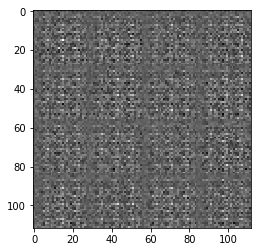

Epoch 0/2:	DLoss: 1.0144, GLoss: 0.9732
Epoch 0/2:	DLoss: 1.6256, GLoss: 0.5658
Epoch 0/2:	DLoss: 0.9328, GLoss: 1.4097
Epoch 0/2:	DLoss: 0.7305, GLoss: 1.7637
Epoch 0/2:	DLoss: 1.4369, GLoss: 3.7334
Image mode: L
Max of images: 0.3018910586833954 -0.49544188380241394


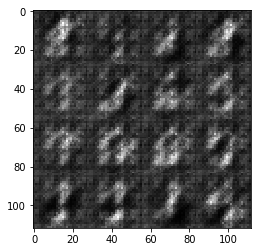

Epoch 0/2:	DLoss: 1.2429, GLoss: 0.7066
Epoch 0/2:	DLoss: 1.0332, GLoss: 0.9399
Epoch 0/2:	DLoss: 0.7952, GLoss: 1.4171
Epoch 0/2:	DLoss: 1.3512, GLoss: 3.1099
Epoch 0/2:	DLoss: 0.9131, GLoss: 1.3370
Image mode: L
Max of images: 0.49995654821395874 -0.5


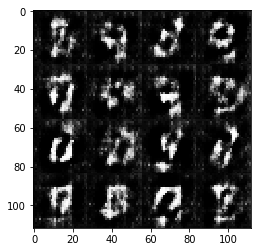

Epoch 0/2:	DLoss: 1.2676, GLoss: 0.6947
Epoch 0/2:	DLoss: 1.0195, GLoss: 0.8793
Epoch 0/2:	DLoss: 1.0396, GLoss: 0.9520
Epoch 0/2:	DLoss: 1.1093, GLoss: 0.7427
Epoch 0/2:	DLoss: 1.1912, GLoss: 2.1417
Image mode: L
Max of images: 0.49999937415122986 -0.5


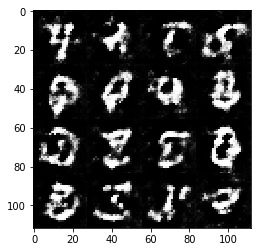

Epoch 0/2:	DLoss: 1.0907, GLoss: 0.8053
Epoch 0/2:	DLoss: 0.9914, GLoss: 1.7412
Epoch 0/2:	DLoss: 0.8720, GLoss: 1.5886
Epoch 0/2:	DLoss: 1.0840, GLoss: 0.7702
Epoch 0/2:	DLoss: 0.9947, GLoss: 0.8991
Image mode: L
Max of images: 0.5 -0.5


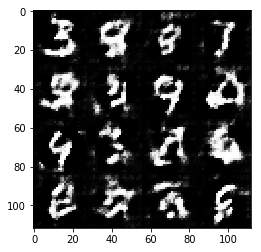

Epoch 0/2:	DLoss: 1.0099, GLoss: 0.8927
Epoch 0/2:	DLoss: 1.0095, GLoss: 0.9247
Epoch 0/2:	DLoss: 0.9622, GLoss: 1.1793
Epoch 1/2:	DLoss: 1.0174, GLoss: 0.8662
Epoch 1/2:	DLoss: 1.1193, GLoss: 0.7664
Image mode: L
Max of images: 0.4999990165233612 -0.5


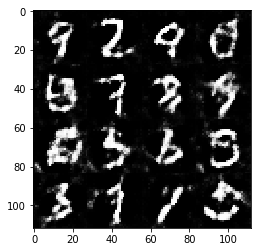

Epoch 1/2:	DLoss: 0.9051, GLoss: 1.4049
Epoch 1/2:	DLoss: 0.9973, GLoss: 1.5659
Epoch 1/2:	DLoss: 1.0094, GLoss: 1.0624
Epoch 1/2:	DLoss: 1.0594, GLoss: 1.7902
Epoch 1/2:	DLoss: 1.0041, GLoss: 1.0029
Image mode: L
Max of images: 0.4999959468841553 -0.5


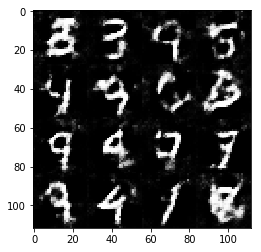

Epoch 1/2:	DLoss: 1.0760, GLoss: 0.8162
Epoch 1/2:	DLoss: 1.2040, GLoss: 2.3947
Epoch 1/2:	DLoss: 0.9416, GLoss: 1.4754
Epoch 1/2:	DLoss: 0.9477, GLoss: 1.1931
Epoch 1/2:	DLoss: 1.0841, GLoss: 1.6675
Image mode: L
Max of images: 0.4999997913837433 -0.5


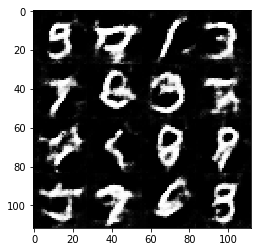

Epoch 1/2:	DLoss: 1.0524, GLoss: 0.8683
Epoch 1/2:	DLoss: 1.1174, GLoss: 1.1339
Epoch 1/2:	DLoss: 1.0047, GLoss: 1.2381
Epoch 1/2:	DLoss: 1.0237, GLoss: 1.2348
Epoch 1/2:	DLoss: 1.1814, GLoss: 0.6553
Image mode: L
Max of images: 0.49999985098838806 -0.5


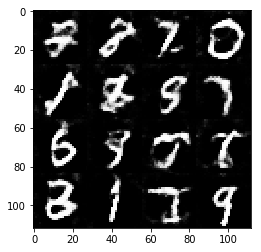

Epoch 1/2:	DLoss: 0.9718, GLoss: 0.9862
Epoch 1/2:	DLoss: 0.9442, GLoss: 1.1501
Epoch 1/2:	DLoss: 1.2056, GLoss: 0.6841
Epoch 1/2:	DLoss: 1.2052, GLoss: 1.7063
Epoch 1/2:	DLoss: 0.9329, GLoss: 1.5215
Image mode: L
Max of images: 0.5 -0.5


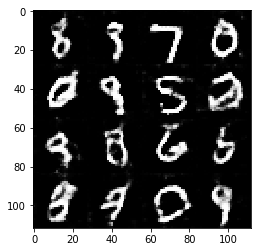

Epoch 1/2:	DLoss: 1.0825, GLoss: 0.7615


In [35]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

28 28 3
Epoch 0/1:	DLoss: 19.1216, GLoss: 0.0000
Image mode: RGB
Max of images: 0.242451474070549 -0.21273523569107056


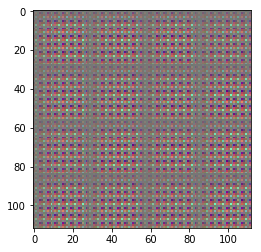

Epoch 0/1:	DLoss: 1.3310, GLoss: 4.0617
Epoch 0/1:	DLoss: 1.1000, GLoss: 2.5512
Epoch 0/1:	DLoss: 0.7778, GLoss: 1.6140
Epoch 0/1:	DLoss: 0.9153, GLoss: 1.1144
Epoch 0/1:	DLoss: 1.1327, GLoss: 1.1027
Image mode: RGB
Max of images: 0.48731479048728943 -0.49999967217445374


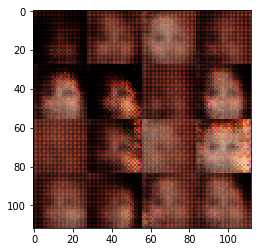

Epoch 0/1:	DLoss: 1.1996, GLoss: 1.1352
Epoch 0/1:	DLoss: 1.0826, GLoss: 1.0187
Epoch 0/1:	DLoss: 1.4067, GLoss: 1.0252
Epoch 0/1:	DLoss: 1.4152, GLoss: 0.7668
Epoch 0/1:	DLoss: 1.3885, GLoss: 0.8356
Image mode: RGB
Max of images: 0.49998223781585693 -0.49999961256980896


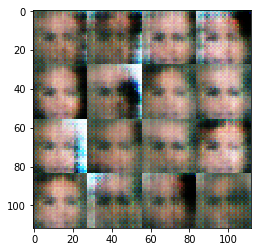

Epoch 0/1:	DLoss: 1.2018, GLoss: 0.8979
Epoch 0/1:	DLoss: 1.3211, GLoss: 0.6709
Epoch 0/1:	DLoss: 1.4856, GLoss: 0.7788
Epoch 0/1:	DLoss: 1.4008, GLoss: 0.9609
Epoch 0/1:	DLoss: 1.5649, GLoss: 0.7845
Image mode: RGB
Max of images: 0.49807024002075195 -0.4999995231628418


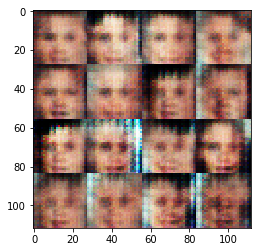

Epoch 0/1:	DLoss: 1.3597, GLoss: 0.7956
Epoch 0/1:	DLoss: 1.7376, GLoss: 0.4299
Epoch 0/1:	DLoss: 1.3213, GLoss: 0.8222
Epoch 0/1:	DLoss: 1.4444, GLoss: 0.7344
Epoch 0/1:	DLoss: 1.3842, GLoss: 0.6532
Image mode: RGB
Max of images: 0.49977344274520874 -0.5


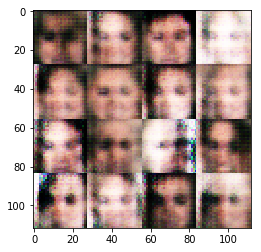

Epoch 0/1:	DLoss: 1.7895, GLoss: 1.5751
Epoch 0/1:	DLoss: 1.4884, GLoss: 1.0576
Epoch 0/1:	DLoss: 1.6919, GLoss: 0.9453
Epoch 0/1:	DLoss: 1.7344, GLoss: 1.5010
Epoch 0/1:	DLoss: 1.2079, GLoss: 0.8524
Image mode: RGB
Max of images: 0.49976933002471924 -0.49999991059303284


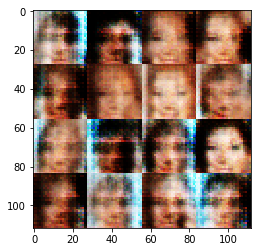

Epoch 0/1:	DLoss: 1.5682, GLoss: 1.7213
Epoch 0/1:	DLoss: 1.2726, GLoss: 0.8903
Epoch 0/1:	DLoss: 1.5703, GLoss: 1.8873
Epoch 0/1:	DLoss: 1.4896, GLoss: 0.7947
Epoch 0/1:	DLoss: 1.2354, GLoss: 1.3899
Image mode: RGB
Max of images: 0.4985109567642212 -0.5


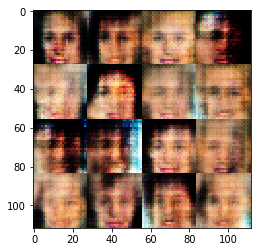

Epoch 0/1:	DLoss: 1.1753, GLoss: 1.0519
Epoch 0/1:	DLoss: 1.3696, GLoss: 0.7840
Epoch 0/1:	DLoss: 1.5063, GLoss: 0.7404
Epoch 0/1:	DLoss: 1.2543, GLoss: 0.8763
Epoch 0/1:	DLoss: 1.3770, GLoss: 0.7229
Image mode: RGB
Max of images: 0.4995069205760956 -0.5


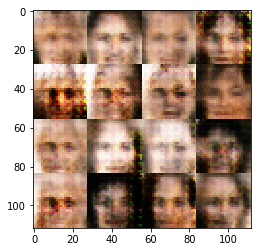

Epoch 0/1:	DLoss: 1.2817, GLoss: 1.1165
Epoch 0/1:	DLoss: 1.4797, GLoss: 0.8623
Epoch 0/1:	DLoss: 1.1833, GLoss: 0.9058
Epoch 0/1:	DLoss: 1.5296, GLoss: 1.2963
Epoch 0/1:	DLoss: 1.3365, GLoss: 0.8383
Image mode: RGB
Max of images: 0.4999956786632538 -0.49999934434890747


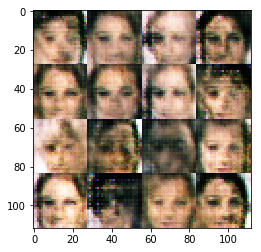

Epoch 0/1:	DLoss: 1.2223, GLoss: 1.0149
Epoch 0/1:	DLoss: 1.2129, GLoss: 1.2546
Epoch 0/1:	DLoss: 1.3392, GLoss: 0.8099
Epoch 0/1:	DLoss: 1.4108, GLoss: 0.8399
Epoch 0/1:	DLoss: 1.3780, GLoss: 1.4643
Image mode: RGB
Max of images: 0.49875497817993164 -0.49999645352363586


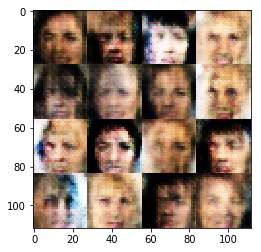

Epoch 0/1:	DLoss: 1.7054, GLoss: 0.3948
Epoch 0/1:	DLoss: 1.3939, GLoss: 1.4562
Epoch 0/1:	DLoss: 1.3659, GLoss: 0.6669
Epoch 0/1:	DLoss: 1.5792, GLoss: 0.5219
Epoch 0/1:	DLoss: 1.3725, GLoss: 0.5687
Image mode: RGB
Max of images: 0.4997614622116089 -0.499422162771225


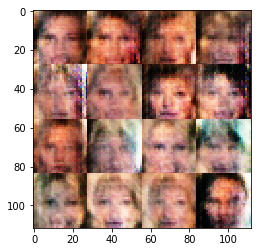

Epoch 0/1:	DLoss: 1.4183, GLoss: 0.8899
Epoch 0/1:	DLoss: 1.2439, GLoss: 0.9221
Epoch 0/1:	DLoss: 1.1557, GLoss: 0.9528
Epoch 0/1:	DLoss: 1.2967, GLoss: 0.7486
Epoch 0/1:	DLoss: 1.3407, GLoss: 0.7275
Image mode: RGB
Max of images: 0.49595585465431213 -0.49999839067459106


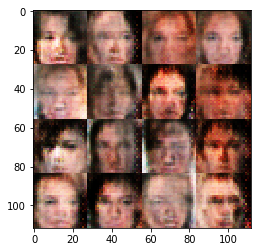

Epoch 0/1:	DLoss: 1.3185, GLoss: 0.8841
Epoch 0/1:	DLoss: 1.3260, GLoss: 0.6489
Epoch 0/1:	DLoss: 1.2216, GLoss: 1.0910
Epoch 0/1:	DLoss: 1.2874, GLoss: 0.7895
Epoch 0/1:	DLoss: 1.2727, GLoss: 0.8881
Image mode: RGB
Max of images: 0.49891194701194763 -0.49999964237213135


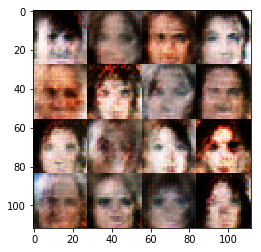

Epoch 0/1:	DLoss: 1.3178, GLoss: 0.8919
Epoch 0/1:	DLoss: 1.2942, GLoss: 0.9838
Epoch 0/1:	DLoss: 1.4515, GLoss: 1.0082
Epoch 0/1:	DLoss: 1.2917, GLoss: 1.3490
Epoch 0/1:	DLoss: 1.2291, GLoss: 0.9774
Image mode: RGB
Max of images: 0.4999736249446869 -0.4997497797012329


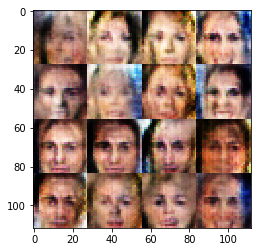

Epoch 0/1:	DLoss: 1.3258, GLoss: 1.2966
Epoch 0/1:	DLoss: 1.3192, GLoss: 0.8307
Epoch 0/1:	DLoss: 1.7957, GLoss: 0.3407
Epoch 0/1:	DLoss: 1.4039, GLoss: 0.5893
Epoch 0/1:	DLoss: 1.0629, GLoss: 0.8950
Image mode: RGB
Max of images: 0.49988433718681335 -0.4997257590293884


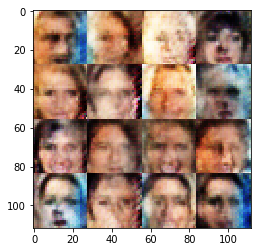

Epoch 0/1:	DLoss: 1.3459, GLoss: 0.7368
Epoch 0/1:	DLoss: 1.2208, GLoss: 0.8513
Epoch 0/1:	DLoss: 1.5228, GLoss: 1.8838
Epoch 0/1:	DLoss: 1.2490, GLoss: 0.7641
Epoch 0/1:	DLoss: 1.3565, GLoss: 0.9568
Image mode: RGB
Max of images: 0.49952301383018494 -0.49995192885398865


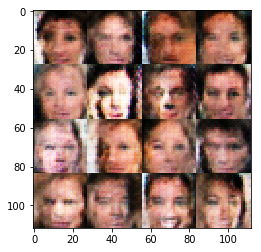

Epoch 0/1:	DLoss: 1.2534, GLoss: 0.9283
Epoch 0/1:	DLoss: 1.2373, GLoss: 0.9251
Epoch 0/1:	DLoss: 1.2822, GLoss: 1.1544
Epoch 0/1:	DLoss: 1.2745, GLoss: 1.1056


In [36]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.